# Specimage module for Myelin Raman data
## 2016.10.06 MCR analysis of joint images

First, we have to import a few modules. Notice that we also add the path to where we can find the **specimage** module before importing it. For more info, see notebook from 20161005

In [1]:
%load_ext autoreload
%autoreload 2
import sys
# change next line to the directory where you have the specimage.py file
sys.path.append('/home/leo/Academic/Projects/150-savvy/060.python')
from specimage import *
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rpy2.robjects, rpy2.robjects.numpy2ri # read Rdata objects from R 

Now we are ready to read the Matlab file into the specimage object (see previous notebook for more detailed info)

In [13]:
path = "/home/leo/Academic/Projects/150-savvy/050.received_data/201609.MyelinRaman/"
wl_axis = np.array([thisline.rstrip() for thisline in open(path + "02.wl_axis.txt")],dtype=float)
pairfiles = [re.split('\s+',thisline.rstrip()) for thisline in open(path + "02.file_shape.txt")]
files = [[x[0]+".Rdata",x[1]+"LEFT.Rdata", x[1]+"RIGHT.Rdata"] for x in pairfiles]

b_row = SpecImage()
b     = SpecImage()

for f_idx in range(len(pairfiles)):
    # read each file into a specimage object
    rpy2.robjects.r['load'](path+pairfiles[f_idx][0]+".Rdata")
    y=rpy2.robjects.numpy2ri.ri2py(rpy2.robjects.r['x'])
    a=SpecImage()
    a.wl = wl_axis # from file with wavelength numbers
    a.description = pairfiles[f_idx][0]
    n_y = y.shape[0]; n_x = y.shape[1]
    a.xy = np.array([[i,j] for i in range(n_x) for j in range(n_y)],dtype=float)
    a.spc = np.array([y[j,i] for i in range(n_x) for j in range(n_y)],dtype=float)
    a.idx = np.arange(n_y * n_x)
    # preprocessing 
    a.set_wavelength_interval(800,1800)
    a.remove_cosmic_spikes(n_iter=1,sd_threshold=4)
    a.remove_noisy_pixels()
    a.interpolate_spline(frac=1.)
    a.rescale_sum()
    #joint image
    if f_idx and not f_idx%3: # 3,6, 
        b.append_specimage(b_row, location=1)
        b_row = SpecImage()
    b_row.append_specimage(a, location=0, rescale=[1,1])
    print ("finished ", pairfiles[f_idx][0]+" ("+str(n_y*n_x)+")", end="\n ")
b.append_specimage(b_row, location=1)

fl=gzip.open(path+"mcr_wl_tmp.gz", "w"); pickle.dump([a.wl],fl,2); fl.close() ## save wavelengths for MCR


finished  c0.1 (7320)
 finished  c0.2 (11319)
 finished  c0.3 (5775)
 finished  s14.1 (12956)
 finished  s14.2 (7344)
 finished  s14.3 (7412)
 finished  s3.1 (10275)
 finished  s3.2 (5940)
 finished  s3.3 (12008)
 finished  d14.1 (11457)
 finished  d14.2 (16000)
 finished  d14.3 (9801)
 finished  r21.1 (11815)
 finished  r21.2 (5800)
 finished  r21.3 (7605)
 finished  r28.1 (11907)
 finished  r28.2 (12090)
 finished  r28.3 (11753)
 

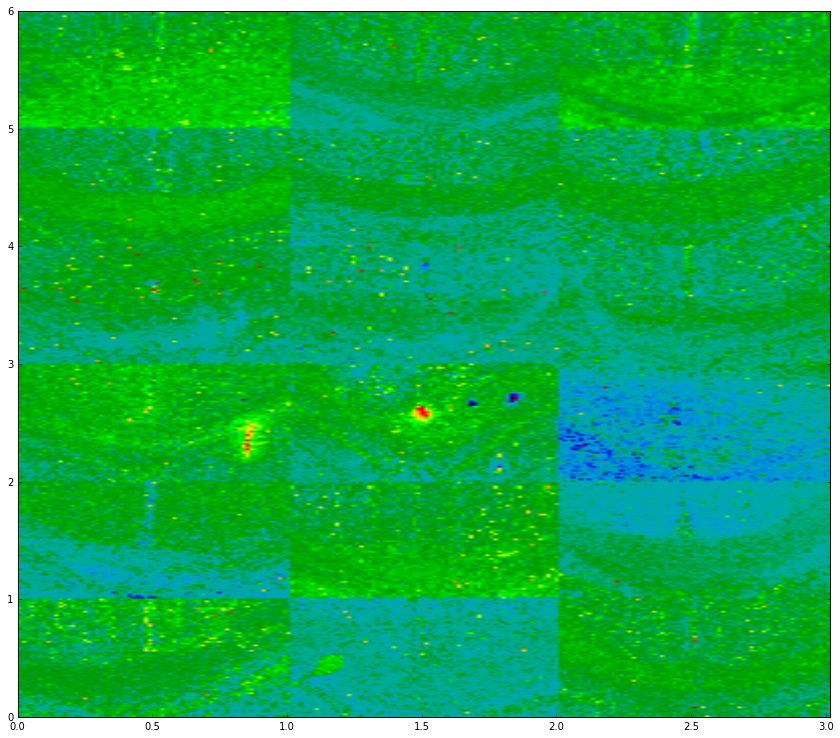

In [15]:
fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
int1 = np.array([sum(spec[200:400]) for spec in b.spc])
Z, ext = create_grid_imshow(b.xy, int1, resolution=400)
im = axes.imshow(Z,extent=ext, aspect='auto', cmap=plt.get_cmap("spectral"))

In [16]:
ab_estim, em_estim, resid = b.find_endmember_abundance_MCR(n_members=4, normalize=False, randomize=True,closure=False)
## save endmembers and abundances to file
fl=gzip.open(path+"mcr_estim.gz", "w"); pickle.dump([ab_estim, em_estim],fl,2); fl.close()
#fl=gzip.open(path+"mcr_estim.gz", "r"); ab_estim, em_estim = pickle.load(fl); fl.close()

finished in 14 iterations


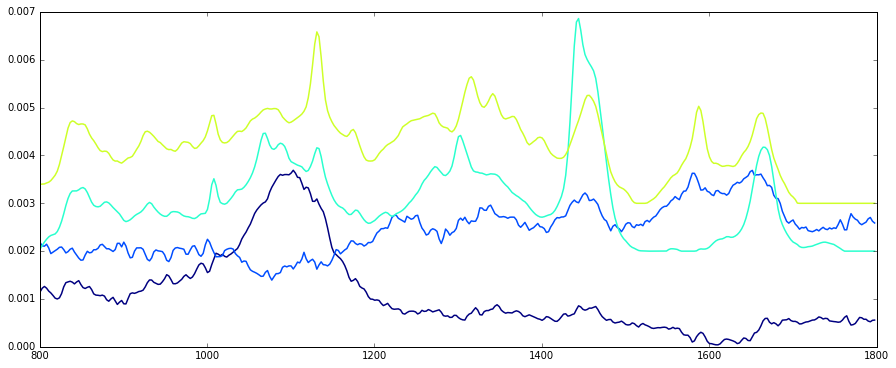

In [18]:
fig, axes = plt.subplots(1) ; fig.set_size_inches(15, 6)
for i in range(em_estim.shape[0]):
    axes.plot(a.wl, 0.001*i +  em_estim[i], linewidth=1.5, c=plt.cm.jet(float(i)/5.))

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


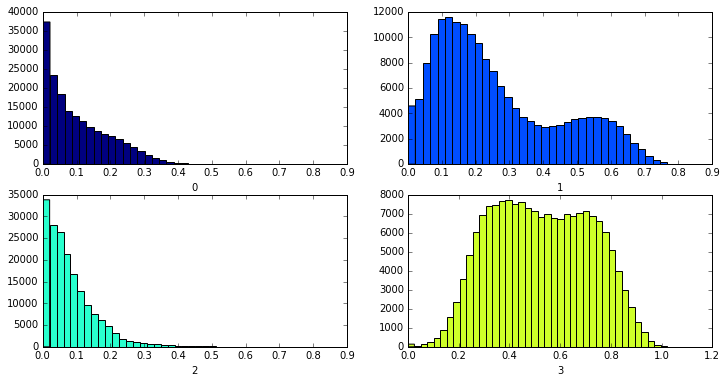

In [7]:
fig, axes = plt.subplots(2,2) ; fig.set_size_inches(12, 6)
for i in range(4):
    axes[i/2, i%2].hist(ab_estim[:,i],40, color=plt.cm.jet(float(i)/5.))
    axes[i/2, i%2].set_xlabel(str(i))

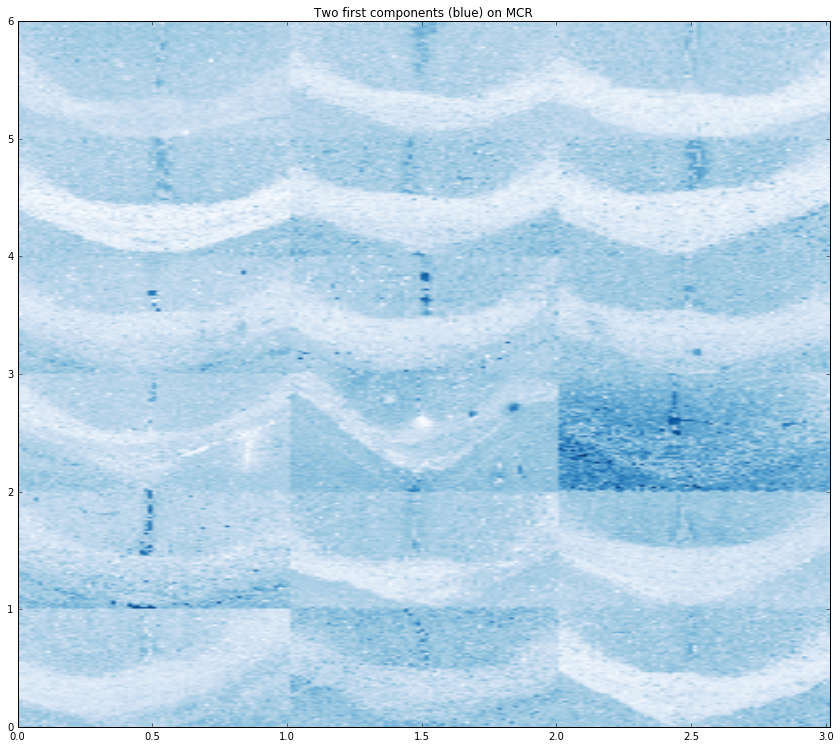

In [34]:
fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
Z, ext = create_grid_imshow(b.xy, ab_estim[:,0], resolution=400)
im = axes.imshow(Z,extent=ext, aspect='auto', cmap=plt.get_cmap("Blues"))
axes.set_title("Two first components (blue) on MCR")

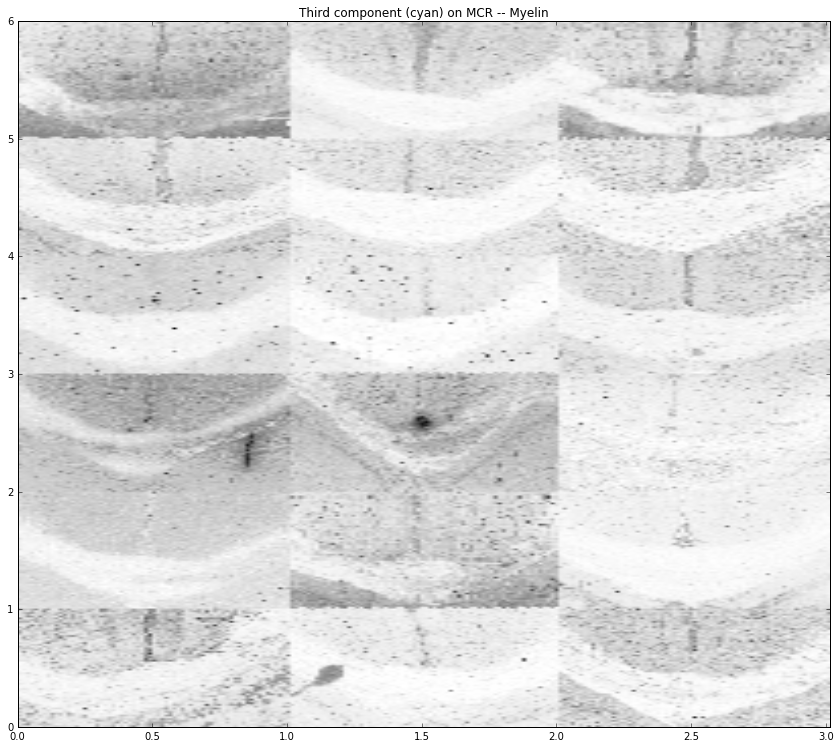

In [35]:
fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
Z, ext = create_grid_imshow(b.xy, ab_estim[:,1], resolution=400)
im = axes.imshow(Z,extent=ext, aspect='auto', cmap=plt.get_cmap("Greys"))
axes.set_title("Third component (cyan) on MCR -- Myelin")

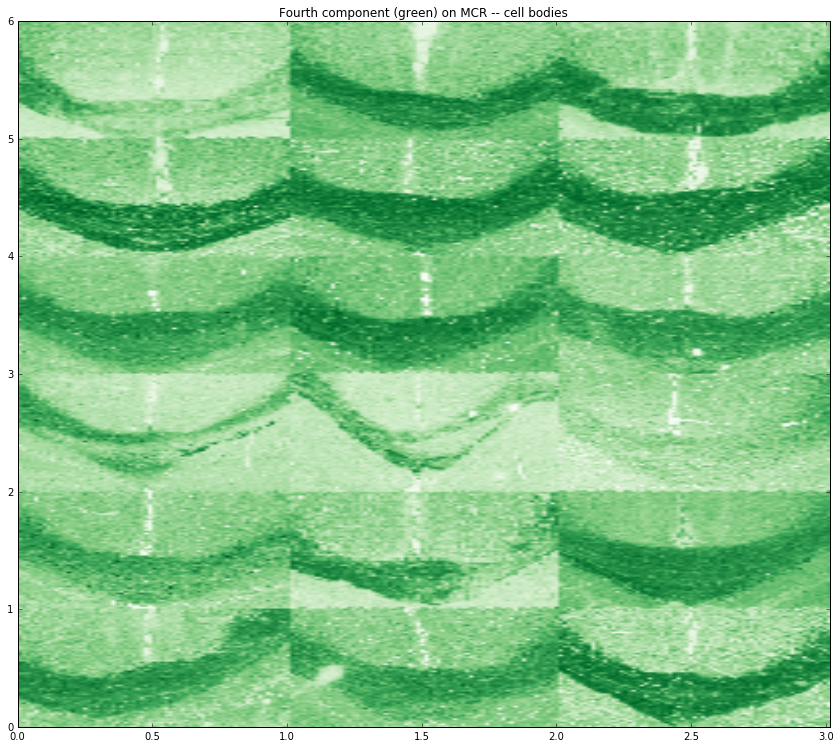

In [36]:
fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
Z, ext = create_grid_imshow(b.xy, ab_estim[:,2], resolution=400)
im = axes.imshow(Z,extent=ext, aspect='auto', cmap=plt.get_cmap("Greens"))
axes.set_title("Fourth component (green) on MCR -- cell bodies")